In [109]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
#import scipy
from statsmodels.iolib.summary2 import summary_col
from functions.find_bubbles import *

In [2]:
style.use('ggplot')

# Appendix A: Model dynamics

## A1 Short-baseline model

In [3]:
NRUNS = 25

In [4]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [5]:
burn_in_period = 250

In [6]:
params

{'ticks': 850,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 0.0530163128919286,
 'spread_max': 0.004087,
 'init_stocks': 50,
 'trader_sample_size': 19,
 'horizon': 100,
 'trades_per_tick': 3,
 'std_noise': 0.15863974,
 'w_random': 0.056454,
 'strat_share_chartists': 0.20454462,
 'base_risk_aversion': 6.05054016,
 'fundamentalist_horizon_multiplier': 2.22042767,
 'mutation_intensity': 0.47684635,
 'average_learning_ability': 0.9962696}

In [7]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19
Start of simulation  20
Start of simulation  21
Start of simulation  22
Start of simulation  23
Start of simulation  24


In [8]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=200)

Establish confidence interval for average prices

In [9]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

In [10]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row] / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

Identify sentiment 

In [11]:
def market_sentiment_in_round(order_book, t):
    return sum(np.array(order_book.sentiment_history[t]) / len(order_book.sentiment_history[t]))

In [12]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

av_lambda = []
lo_lambda = []
up_lambda = []

for t in range(len(orbs[0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    lmbda = np.array([c_sents]) / (np.array([c_sents]) + np.array([f_sents]))
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_interval(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_interval(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_interval(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)
    
    av_lambda.append(np.mean(lmbda))
    low, up = confidence_interval(lmbda, np.mean(lmbda))
    lo_lambda.append(low)
    up_lambda.append(up)

Identify individual agent wealth changes

In [13]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [14]:
len(ginis_ot)

25

In [15]:
# first, order all profits, then get average profit and conf intervals 
av_ordered_profits = []
lcf_ordered_profits = []
ucf_ordered_profits = []

ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
for a in range(len(ordered_profits[0])):
    a_profits = [list(p)[a] for p in ordered_profits]
    av_ordered_profits.append(np.mean(a_profits))
    low, up = confidence_interval(a_profits, np.mean(a_profits))
    lcf_ordered_profits.append(low)
    ucf_ordered_profits.append(up)

Import all bubbles, and identify wins and losses 

Calculate the inequality stats Gini, Palma, and Twenty-twenty

In [24]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_twtw_ot = []
low_twtw_ot = []
up_twtw_ot = []

for t in range(burn_in_period, params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)
    
    t_twtw = [tw[t] for tw in twtws_ot]
    av_twtw_ot.append(np.mean(t_twtw))
    low, up = confidence_interval(t_twtw, np.mean(t_twtw))
    low_twtw_ot.append(low)
    up_twtw_ot.append(up)

In [25]:
mc_prices.mean(axis=1).describe()

count    652.000000
mean     163.547877
std        0.838056
min      161.382841
25%      162.940938
50%      163.672615
75%      164.123529
max      165.497361
dtype: float64

In [26]:
print('Kurtosis = ', pd.Series(mc_prices.mean(axis=1)).kurt())
print('Skew = ', pd.Series(mc_prices.mean(axis=1)).skew())

Kurtosis =  -0.304691713851883
Skew =  -0.3755756098550614


Summary of profit data: 

In [27]:
pd.Series(av_ordered_profits).describe()

count    500.000000
mean      -0.008260
std        0.132249
min       -0.340932
25%       -0.101729
50%       -0.017290
75%        0.077631
max        0.458178
dtype: float64

In [28]:
print('Kurtosis = ', pd.Series(av_ordered_profits).kurt())
print('Skew = ', pd.Series(av_ordered_profits).skew())

Kurtosis =  0.05970891291967684
Skew =  0.35444910055966183


### Plot short-baseline:

1. price + fundamental, 
2. sentiment,
3. Distribution of profit 
4. gini,
5. palma, 
6. twenty twenty 

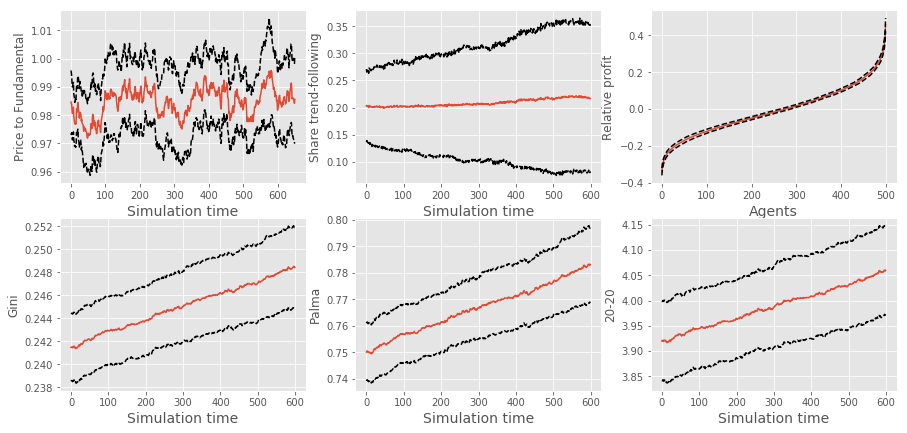

In [29]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

#ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
ax1.plot(mc_prices.index, (mc_prices.mean(axis=1) / mc_fundamentals.mean(axis=1))[:], label='Market')
ax1.plot(mc_prices.index[:-1], lower_c_price, 'k--')
ax1.plot(mc_prices.index[:-1], upper_c_price, 'k--')

ax1.set_ylabel('Price to Fundamental', fontsize='12')

ax2.plot(range(len(av_lambda[burn_in_period:])), av_lambda[burn_in_period:])
ax2.plot(range(len(av_lambda[burn_in_period:])), lo_lambda[burn_in_period:], 'k--')
ax2.plot(range(len(av_lambda[burn_in_period:])), up_lambda[burn_in_period:], 'k--')
ax2.set_ylabel('Share trend-following', fontsize='12')

# ax2.plot(range(len(av_fundamentalist_sentiment[burn_in_period:])), av_fundamentalist_sentiment[burn_in_period:], label='fundamentalist ')
# ax2.plot(range(len(lo_fundamentalist_sentiment[burn_in_period:])), lo_fundamentalist_sentiment[burn_in_period:], 'r--', alpha=0.3)
# ax2.plot(range(len(up_fundamentalist_sentiment[burn_in_period:])), up_fundamentalist_sentiment[burn_in_period:], 'r--', alpha=0.3)
# ax2.set_ylabel('Percentage', fontsize='12')

# ax2.plot(range(len(av_trend_sentiment[burn_in_period:])), av_trend_sentiment[burn_in_period:], label='chartist ')
# ax2.plot(range(len(lo_trend_sentiment[burn_in_period:])), lo_trend_sentiment[burn_in_period:], 'b--', alpha=0.3)
# ax2.plot(range(len(up_trend_sentiment[burn_in_period:])), up_trend_sentiment[burn_in_period:], 'b--', alpha=0.3)

# ax2.plot(range(len(av_random_sentiment[burn_in_period:])), av_random_sentiment[burn_in_period:], 'k', label='random ')
# ax2.plot(range(len(lo_trend_sentiment[burn_in_period:])), lo_random_sentiment[burn_in_period:], 'k--', alpha=0.3)
# ax2.plot(range(len(up_trend_sentiment[burn_in_period:])), up_random_sentiment[burn_in_period:], 'k--', alpha=0.3)
# ax2.set_ylim(0, 1)

ax3.plot(range(len(av_ordered_profits)), av_ordered_profits)
ax3.plot(range(len(av_ordered_profits)), ucf_ordered_profits, 'k--')
ax3.plot(range(len(av_ordered_profits)), lcf_ordered_profits, 'k--')
ax3.set_ylabel('Relative profit', fontsize='12')

ax4.plot(range(len(av_gini_ot[:])), av_gini_ot[:])
ax4.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax4.set_ylabel('Gini', fontsize='12')

ax5.plot(range(len(av_gini_ot[:])), av_palma_ot[:])
ax5.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax5.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax5.set_ylabel('Palma', fontsize='12')

ax6.plot(range(len(av_gini_ot[:])), av_twtw_ot[:])
ax6.plot(range(len(low_gini_ot[:])), low_twtw_ot[:], 'k--')
ax6.plot(range(len(up_gini_ot[:])), up_twtw_ot[:], 'k--')
ax6.set_ylabel('20-20', fontsize='12')

for ax in (ax1, ax2, ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='14')
    
ax3.set_xlabel('Agents', fontsize='14')

fig.savefig('short_baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Correlation structure: 



In [39]:
w = 5

In [113]:
volList = []
delta_P_list = []

ginis_diff_list = []
palmas_diff_list = []
twtw_diff_list = []

ginis_ot_list = []
palmas_ot_list = []
twtw_ot_list = []
for i in range(len(orbs)):
    volList += list((pd.Series(orbs[i].tick_close_price) / pd.Series(orbs[i].fundamental[1:])).rolling(w).std(ddof=0)[w-1:-2])
    delta_P_list += list((pd.Series(orbs[i].tick_close_price) / pd.Series(orbs[i].fundamental[1:])).diff()[w-1:-2])
    ginis_diff_list += list(np.diff(ginis_ot[i]))[w-2:]
    palmas_diff_list += list(np.diff(palmas_ot[i]))[w-2:]
    twtw_diff_list += list(np.diff(twtws_ot[i]))[w-2:]
    
    ginis_ot_list += list(ginis_ot[i])[w-1:]
    palmas_ot_list += list(palmas_ot[i])[w-1:]
    twtw_ot_list += list(twtws_ot[i])[w-1:]

In [114]:
data_ineq = pd.DataFrame({'stdev_p': volList, 'delta_p': delta_P_list, 
                          'delta_gini': ginis_diff_list, 'delta_palma': palmas_diff_list, 'delta_twtw': palmas_diff_list,
                         'gini': ginis_ot_list, 'palma': palmas_ot_list, 'twtw': twtw_ot_list})
data_ineq['const'] = 1

### 1 Higher inequality ... price to fundamentals variance 

$\sigma^{pd} = \alpha + \beta X + \epsilon$

where X contains the inequality variables. 

TODO: 

1. add lambda 
2. add lag to inequality variables
3. perform same regression for steady state


In [125]:
# TODO  add lambda add lag to gini_palma_twtw: 
reg_wi = sm.OLS(endog=data_ineq['stdev_p'], exog=data_ineq[['const', 'gini', 'palma', 'twtw']], missing='drop').fit()

In [126]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg_wi],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['stdev price'],
                            info_dict=info_dict,
                            regressor_order=['const', 'gini', 'palma', 'twtw'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

       Table - OLS Regressions
                     stdev price     
-------------------------------------
const            0.0007              
                 (0.0016)            
gini             0.1378***           
                 (0.0255)            
palma            -0.0314***          
                 (0.0044)            
twtw             -0.0013***          
                 (0.0005)            
R-squared        0.003346236376229883
No. observations 21150               
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## 2 higher inequality associated with more or less price variance. Share trend following? 

$c = \alpha + \beta_1 \sigma^{pd} + \beta_2 \delta^{pd} + \epsilon $

In [122]:
# add lambda? 
reg1_wi = sm.OLS(endog=data_ineq['delta_gini'], exog=data_ineq[['const', 'stdev_p', 'delta_p']], missing='drop').fit()
reg2_wi = sm.OLS(endog=data_ineq['delta_palma'], exog=data_ineq[['const', 'stdev_p', 'delta_p']], missing='drop').fit()
reg3_wi = sm.OLS(endog=data_ineq['delta_twtw'], exog=data_ineq[['const', 'stdev_p', 'delta_p']], missing='drop').fit()

In [123]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1_wi, reg2_wi, reg3_wi],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'stdev_p', 'delta_p'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                             Table - OLS Regressions
                          Gini                 Palma                 20-20        
----------------------------------------------------------------------------------
const            0.2439***             0.0001***             0.0001***            
                 (0.0001)              (0.0000)              (0.0000)             
stdev_p          -0.0615***            -0.0070***            -0.0070***           
                 (0.0152)              (0.0026)              (0.0026)             
delta_p          0.0281***             -0.0067***            -0.0067***           
                 (0.0084)              (0.0014)              (0.0014)             
R-squared        0.0012955965609793285 0.0014139741737344558 0.0014139741737344558
No. observations 21150                 21150                 21150                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## A2 Long-baseline model

In [127]:
NRUNS = 2

In [128]:
params['ticks'] = 10000#0

In [129]:
params

{'ticks': 10000,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 0.0530163128919286,
 'spread_max': 0.004087,
 'init_stocks': 50,
 'trader_sample_size': 19,
 'horizon': 100,
 'trades_per_tick': 3,
 'std_noise': 0.15863974,
 'w_random': 0.056454,
 'strat_share_chartists': 0.20454462,
 'base_risk_aversion': 6.05054016,
 'fundamentalist_horizon_multiplier': 2.22042767,
 'mutation_intensity': 0.47684635,
 'average_learning_ability': 0.9962696}

In [130]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1


In [131]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=200)

Establish confidence intervals:

Identify sentiment:

In [146]:
def market_sentiment_in_round(order_book, t):
    return sum(np.array(order_book.sentiment_history[t]) / len(order_book.sentiment_history[t]))

In [147]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row] / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

Identify sentiment 

In [148]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

av_lambda = []
lo_lambda = []
up_lambda = []

for t in range(len(orbs[0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    lmbda = np.array([c_sents]) / (np.array([c_sents]) + np.array([f_sents]))
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_interval(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_interval(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_interval(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)
    
    av_lambda.append(np.mean(lmbda))
    low, up = confidence_interval(lmbda, np.mean(lmbda))
    lo_lambda.append(low)
    up_lambda.append(up)

Identify individual agent wealth changes

In [149]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [150]:
len(ginis_ot)

2

In [151]:
# first, order all profits, then get average profit and conf intervals 
av_ordered_profits = []
lcf_ordered_profits = []
ucf_ordered_profits = []

ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
for a in range(len(ordered_profits[0])):
    a_profits = [list(p)[a] for p in ordered_profits]
    av_ordered_profits.append(np.mean(a_profits))
    low, up = confidence_interval(a_profits, np.mean(a_profits))
    lcf_ordered_profits.append(low)
    ucf_ordered_profits.append(up)

Calculate the inequality stats Gini, Palma, and Twenty-twenty

In [152]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_twtw_ot = []
low_twtw_ot = []
up_twtw_ot = []

for t in range(burn_in_period, params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)
    
    t_twtw = [tw[t] for tw in twtws_ot]
    av_twtw_ot.append(np.mean(t_twtw))
    low, up = confidence_interval(t_twtw, np.mean(t_twtw))
    low_twtw_ot.append(low)
    up_twtw_ot.append(up)

In [153]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row] / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

Identify sentiment 

In [154]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

av_lambda = []
lo_lambda = []
up_lambda = []

for t in range(len(orbs[0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    lmbda = np.array([c_sents]) / (np.array([c_sents]) + np.array([f_sents]))
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_interval(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_interval(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_interval(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)
    
    av_lambda.append(np.mean(lmbda))
    low, up = confidence_interval(lmbda, np.mean(lmbda))
    lo_lambda.append(low)
    up_lambda.append(up)

In [9]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

In [10]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row] / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

Identify sentiment 

In [11]:
def market_sentiment_in_round(order_book, t):
    return sum(np.array(order_book.sentiment_history[t]) / len(order_book.sentiment_history[t]))

In [12]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

av_lambda = []
lo_lambda = []
up_lambda = []

for t in range(len(orbs[0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    lmbda = np.array([c_sents]) / (np.array([c_sents]) + np.array([f_sents]))
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_interval(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_interval(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_interval(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)
    
    av_lambda.append(np.mean(lmbda))
    low, up = confidence_interval(lmbda, np.mean(lmbda))
    lo_lambda.append(low)
    up_lambda.append(up)

Identify individual agent wealth changes

In [13]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [14]:
len(ginis_ot)

25

In [15]:
# first, order all profits, then get average profit and conf intervals 
av_ordered_profits = []
lcf_ordered_profits = []
ucf_ordered_profits = []

ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
for a in range(len(ordered_profits[0])):
    a_profits = [list(p)[a] for p in ordered_profits]
    av_ordered_profits.append(np.mean(a_profits))
    low, up = confidence_interval(a_profits, np.mean(a_profits))
    lcf_ordered_profits.append(low)
    ucf_ordered_profits.append(up)

Import all bubbles, and identify wins and losses 

Calculate the inequality stats Gini, Palma, and Twenty-twenty

In [165]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_twtw_ot = []
low_twtw_ot = []
up_twtw_ot = []

for t in range(burn_in_period, params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(min(up, 1))

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(max(low, 0))
    up_palma_ot.append(up)
    
    t_twtw = [tw[t] for tw in twtws_ot]
    av_twtw_ot.append(np.mean(t_twtw))
    low, up = confidence_interval(t_twtw, np.mean(t_twtw))
    low_twtw_ot.append(max(low, 0))
    up_twtw_ot.append(up)

### Summarize data

Summary of price data:

In [159]:
mc_prices.mean(axis=1).describe()

count    9802.000000
mean      165.889063
std        28.075910
min        88.699672
25%       158.874944
50%       163.478896
75%       168.348602
max       560.826666
dtype: float64

In [139]:
print('Kurtosis = ', pd.Series(mc_prices.mean(axis=1)).kurt())
print('Skew = ', pd.Series(mc_prices.mean(axis=1)).skew())

Kurtosis =  89.8593884682786
Skew =  8.156680269038205


Summary of profit data: 

In [140]:
pd.Series(av_ordered_profits).describe()

count    500.000000
mean       0.049156
std       10.844402
min       -0.942824
25%       -0.787021
50%       -0.648004
75%       -0.434119
max      240.964047
dtype: float64

In [141]:
print('Kurtosis = ', pd.Series(av_ordered_profits).kurt())
print('Skew = ', pd.Series(av_ordered_profits).skew())

Kurtosis =  491.0186056520602
Skew =  22.06649382946858


### Plot

In [142]:
burn_in_period = 0

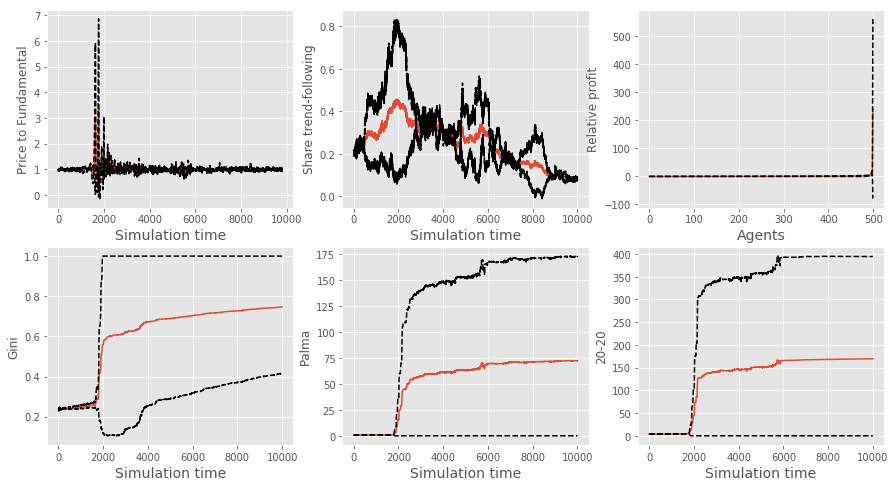

In [167]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8))

#ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
ax1.plot(mc_prices.index, (mc_prices.mean(axis=1) / mc_fundamentals.mean(axis=1))[:], label='Market')
ax1.plot(mc_prices.index[:-1], lower_c_price, 'k--')
ax1.plot(mc_prices.index[:-1], upper_c_price, 'k--')

ax1.set_ylabel('Price to Fundamental', fontsize='12')

ax2.plot(range(len(av_lambda[burn_in_period:])), av_lambda[burn_in_period:])
ax2.plot(range(len(av_lambda[burn_in_period:])), lo_lambda[burn_in_period:], 'k--')
ax2.plot(range(len(av_lambda[burn_in_period:])), up_lambda[burn_in_period:], 'k--')
ax2.set_ylabel('Share trend-following', fontsize='12')

ax3.plot(range(len(av_ordered_profits)), av_ordered_profits)
ax3.plot(range(len(av_ordered_profits)), ucf_ordered_profits, 'k--')
ax3.plot(range(len(av_ordered_profits)), lcf_ordered_profits, 'k--')
ax3.set_ylabel('Relative profit', fontsize='12')

ax4.plot(range(len(av_gini_ot[:])), av_gini_ot[:])
ax4.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax4.set_ylabel('Gini', fontsize='12')

ax5.plot(range(len(av_gini_ot[:])), av_palma_ot[:])
ax5.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax5.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax5.set_ylabel('Palma', fontsize='12')

ax6.plot(range(len(av_gini_ot[:])), av_twtw_ot[:])
ax6.plot(range(len(low_gini_ot[:])), low_twtw_ot[:], 'k--')
ax6.plot(range(len(up_gini_ot[:])), up_twtw_ot[:], 'k--')
ax6.set_ylabel('20-20', fontsize='12')

for ax in (ax1, ax2, ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='14')
    
ax3.set_xlabel('Agents', fontsize='14')

fig.savefig('long_baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Correlation structure: 



In [226]:
w = 5

In [227]:
volList = []
delta_P_list = []

ginis_diff_list = []
palmas_diff_list = []
twtw_diff_list = []

ginis_ot_list = []
palmas_ot_list = []
twtw_ot_list = []
for i in range(len(orbs)):
    volList += list((pd.Series(orbs[i].tick_close_price) / pd.Series(orbs[i].fundamental[1:])).rolling(w).std(ddof=0)[w-1:-2].shift(w*2))
    delta_P_list += list((pd.Series(orbs[i].tick_close_price) / pd.Series(orbs[i].fundamental[1:])).diff()[w-1:-2])
    ginis_diff_list += list(np.diff(ginis_ot[i]))[w-2:]
    palmas_diff_list += list(np.diff(palmas_ot[i]))[w-2:]
    twtw_diff_list += list(np.diff(twtws_ot[i]))[w-2:]
    
    ginis_ot_list += list(ginis_ot[i])[w-1:]
    palmas_ot_list += list(palmas_ot[i])[w-1:]
    twtw_ot_list += list(twtws_ot[i])[w-1:]

In [228]:
data_ineq = pd.DataFrame({'stdev_p': volList, 'delta_p': delta_P_list, 
                          'delta_gini': ginis_diff_list, 'delta_palma': palmas_diff_list, 'delta_twtw': palmas_diff_list,
                         'gini': ginis_ot_list, 'palma': palmas_ot_list, 'twtw': twtw_ot_list})
data_ineq['const'] = 1

In [229]:
len(palmas_diff_list)

19992

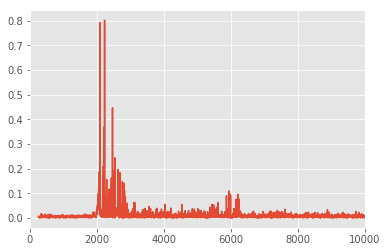

In [236]:
(pd.Series(orbs[i].tick_close_price) / pd.Series(orbs[i].fundamental[1:])).rolling(w).std(ddof=0)[w-1:-2].shift(w*50).plot()

### 1 Higher inequality ... price to fundamentals variance 

$\sigma^{pd} = \alpha + \beta X + \epsilon$

where X contains the inequality variables. 

TODO: 

1. add lambda 
2. add lag to inequality variables
3. perform same regression for steady state


In [230]:
# what I want is the effect of gini, palma, twtw on volatility in the next periods. 
reg_wi = sm.OLS(endog=data_ineq['stdev_p'], exog=data_ineq[['const', 'gini', 'palma', 'twtw']], missing='drop').fit()

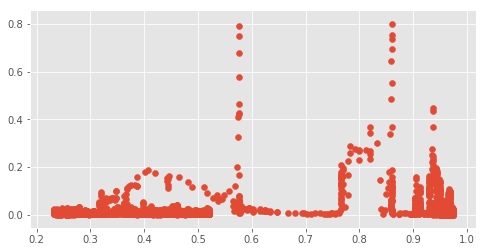

In [231]:
fig, ax1 = plt.subplots(1, 1, figsize=[8,4])

ax1.scatter(data_ineq['gini'], data_ineq['stdev_p'])

In [215]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg_wi],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['stdev price long'],
                            info_dict=info_dict,
                            regressor_order=['const', 'gini', 'palma', 'twtw'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

     Table - OLS Regressions
                  stdev price long
----------------------------------
const            0.1461***        
                 (0.0048)         
gini             -0.6126***       
                 (0.0135)         
palma            -0.0618***       
                 (0.0004)         
twtw             0.0281***        
                 (0.0002)         
R-squared        0.603343127847039
No. observations 18802            
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# Experiment 1

In [8]:
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0
params['ticks'] = 450

In [9]:
NRUNS = 5

In [10]:
share_chartists = [x / 100.0 for x in range(25, 125, 25)]
experiments = len(share_chartists)
share_chartists

[0.25, 0.5, 0.75, 1.0]

In [11]:
trdrs = []
orbs = []
for exp in range(experiments):
    params['strat_share_chartists'] = share_chartists[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4


In [12]:
full_share_chartists = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_share_chartists.append(share_chartists[exp])

## Split data into the four groups


In [13]:
all_trdrs = []
all_orbs = []
for exp in range(experiments):
    all_trdrs.append(trdrs[exp * 5:exp * 5 + 5])
    all_orbs.append(orbs[exp * 5:exp * 5 + 5])

In [14]:
all_mc_prices = []
all_mc_fundamentals = []
for exp in range(experiments):
    mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(all_orbs[exp], burn_in_period=0)
    all_mc_prices.append(mc_prices)
    all_mc_fundamentals.append(mc_fundamentals)

Establish price confidence intervals.

In [15]:
all_lower_c_price = []
all_upper_c_price = []

for exp in range(experiments):
    lower_c_price = []
    upper_c_price = []
    for row in range(len(all_mc_prices[exp])):
        price_range = mc_prices.iloc[row]
        lower, upper = confidence_interval(price_range, np.mean(price_range))
        lower_c_price.append(lower)
        upper_c_price.append(upper)
    
    all_lower_c_price.append(lower_c_price)
    all_upper_c_price.append(upper_c_price)

Identify sentiments

In [18]:
all_av_fundamentalist_sentiment = []
all_lo_fundamentalist_sentiment = []
all_up_fundamentalist_sentiment = []

all_av_trend_sentiment = []
all_lo_trend_sentiment = []
all_up_trend_sentiment = []

all_av_random_sentiment = []
all_lo_random_sentiment = []
all_up_random_sentiment = []

for exp in range(experiments):
    av_fundamentalist_sentiment = []
    lo_fundamentalist_sentiment = []
    up_fundamentalist_sentiment = []

    av_trend_sentiment = []
    lo_trend_sentiment = []
    up_trend_sentiment = []

    av_random_sentiment = []
    lo_random_sentiment = []
    up_random_sentiment = []

    for t in range(len(all_orbs[exp][0].sentiment_history)):
        sentiment = []
        for orderb in all_orbs[exp]:
            sentiment.append(market_sentiment_in_round(orderb, t))
        f_sents = [s[0] for s in sentiment]
        c_sents = [s[1] for s in sentiment]
        r_sents = [s[2] for s in sentiment]
        # calculate the average and conf intervals
        av_fundamentalist_sentiment.append(np.mean(f_sents))
        low, up = confidence_interval(f_sents, np.mean(f_sents))
        lo_fundamentalist_sentiment.append(max(0.0, low))
        up_fundamentalist_sentiment.append(min(1.0, up))

        av_trend_sentiment.append(np.mean(c_sents))
        low, up = confidence_interval(c_sents, np.mean(c_sents))
        lo_trend_sentiment.append(max(0.0, low))
        up_trend_sentiment.append(min(1.0, up))

        av_random_sentiment.append(np.mean(r_sents))
        low, up = confidence_interval(r_sents, np.mean(r_sents))
        lo_random_sentiment.append(max(0.0, low))
        up_random_sentiment.append(min(1.0, up))
    
    all_av_fundamentalist_sentiment.append(av_fundamentalist_sentiment)
    all_lo_fundamentalist_sentiment.append(lo_fundamentalist_sentiment)
    all_up_fundamentalist_sentiment.append(up_fundamentalist_sentiment)

    all_av_trend_sentiment.append(av_trend_sentiment)
    all_lo_trend_sentiment.append(lo_trend_sentiment)
    all_up_trend_sentiment.append(up_trend_sentiment)

    all_av_random_sentiment.append(av_random_sentiment)
    all_lo_random_sentiment.append(lo_random_sentiment)
    all_up_random_sentiment.append(up_random_sentiment)

Identify individual wealth changes:

In [19]:
all_av_ordered_profits = []

for exp in range(experiments):
    profits = []

    # determine the start and end wealth of the bubble
    for seed, traders in enumerate(all_trdrs[exp]):
        money_start = np.array([x.var.money[0] for x in traders])
        stocks_start = np.array([x.var.stocks[0] for x in traders])
        wealth_start = money_start + (stocks_start * all_orbs[exp][seed].tick_close_price[0])

        money_end = np.array([x.var.money[-1] for x in traders])
        stocks_end = np.array([x.var.stocks[-1] for x in traders])
        wealth_end = money_end + (stocks_end * all_orbs[exp][seed].tick_close_price[-1])

        # profits
        profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

    av_ordered_profits = []
    # lcf_ordered_profits = []
    # ucf_ordered_profits = []
    ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
    for a in range(len(ordered_profits[0])):
        a_profits = [list(p)[a] for p in ordered_profits]
        av_ordered_profits.append(np.mean(a_profits))
    #     low, up = confidence_interval(a_profits, np.mean(a_profits))
    #     lcf_ordered_profits.append(max(-1.0, low))
    #     ucf_ordered_profits.append(up)
    all_av_ordered_profits.append(av_ordered_profits)
    

### Summarize price & profits data

In [20]:
pd.DataFrame({'lambda = 0.25p': all_mc_prices[0].mean(axis=1),  
              'lambda = 0.5p':all_mc_prices[1].mean(axis=1), 
              'lambda = 0.75p': all_mc_prices[2].mean(axis=1), 'lambda = 1.0p': all_mc_prices[3].mean(axis=1)}).describe()

,lambda = 0.25p,lambda = 0.5p,lambda = 0.75p,lambda = 1.0p
count,452.000000,452.000000,452.000000,452.000000
mean,160.688634,204.886456,310.179713,455.512877
std,7.520740,107.810526,257.435468,542.455915
min,139.014705,50.487839,38.981508,6.313816
25%,160.169835,135.641761,147.617909,32.306578
50%,161.944689,167.414729,189.261843,179.140865
75%,165.662880,243.849380,364.011321,760.939758
max,170.895003,552.217704,1244.067407,2935.119332


In [34]:
print('Skews : ', [pd.Series(p.mean(axis=1)).skew() for p in all_mc_prices])
print('Kurts : ', [pd.Series(p.mean(axis=1)).kurtosis() for p in all_mc_prices])

Skews :  [-1.5258681115078994, 1.249080313257102, 1.8305410384314695, 1.6945311896960882]
Kurts :  [1.791364128147983, 0.9668910955650696, 2.867368068718472, 3.719753750160621]


In [27]:
pd.DataFrame({'lambda = 0.25p': all_av_ordered_profits[0],  
              'lambda = 0.5p':all_av_ordered_profits[1], 
              'lambda = 0.75p': all_av_ordered_profits[2], 'lambda = 1.0p': all_av_ordered_profits[3]}).describe()

,lambda = 0.25p,lambda = 0.5p,lambda = 0.75p,lambda = 1.0p
count,500.000000,500.000000,500.000000,500.000000
mean,-0.016065,0.287809,-0.307893,1.828850
std,0.113614,5.036385,2.699523,18.154470
min,-0.288787,-0.974023,-0.989774,-0.983213
25%,-0.100330,-0.899436,-0.858618,-0.661001
50%,-0.022451,-0.816175,-0.743327,-0.246732
75%,0.056043,-0.540212,-0.526721,0.499833
max,0.358184,73.645282,48.041324,380.133352


In [32]:
print('Skews : ', [pd.Series(op).skew() for op in all_av_ordered_profits])
print('Kurts : ', [pd.Series(op).kurtosis() for op in all_av_ordered_profits])

Skews :  [0.295392072084788, 9.011212274406304, 13.434505745260154, 18.58737529264149]
Kurts :  [-0.14895544949334827, 105.807444921674, 218.9992307307185, 380.88969297970004]


In [23]:
burn_in_period = 0

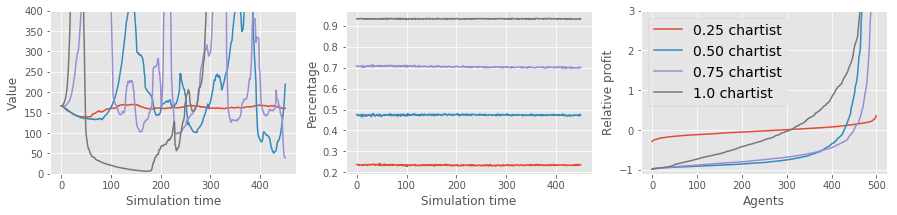

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))

ax1.plot(all_mc_prices[0].index, all_mc_prices[0].mean(axis=1), label='Market0')
ax1.plot(all_mc_prices[1].index, all_mc_prices[1].mean(axis=1), label='Market1')
ax1.plot(all_mc_prices[2].index, all_mc_prices[2].mean(axis=1), label='Market2')
ax1.plot(all_mc_prices[3].index, all_mc_prices[3].mean(axis=1), label='Market3')
ax1.set_ylim(0, 400)
#ax1.plot(mc_prices.index, lower_c_price, 'b--', alpha=0.3)
#ax1.plot(mc_prices.index, upper_c_price, 'b--', alpha=0.3)

ax1.set_ylabel('Value', fontsize='12')


#ax2.plot(range(len(av_fundamentalist_sentiment[burn_in_period:])), av_fundamentalist_sentiment[burn_in_period:], label='fundamentalist ')
ax2.set_ylabel('Percentage', fontsize='12')

ax2.plot(range(len(all_av_trend_sentiment[0][burn_in_period:])), all_av_trend_sentiment[0][burn_in_period:], label='chartist ')
ax2.plot(range(len(all_av_trend_sentiment[1][burn_in_period:])), all_av_trend_sentiment[1][burn_in_period:], label='chartist ')
ax2.plot(range(len(all_av_trend_sentiment[2][burn_in_period:])), all_av_trend_sentiment[2][burn_in_period:], label='chartist ')
ax2.plot(range(len(all_av_trend_sentiment[3][burn_in_period:])), all_av_trend_sentiment[3][burn_in_period:], label='chartist ')

ax3.plot(range(len(all_av_ordered_profits[0])), all_av_ordered_profits[0], label='0.25 chartist')
ax3.plot(range(len(all_av_ordered_profits[0])), all_av_ordered_profits[1], label='0.50 chartist')
ax3.plot(range(len(all_av_ordered_profits[0])), all_av_ordered_profits[2], label='0.75 chartist')
ax3.plot(range(len(all_av_ordered_profits[0])), all_av_ordered_profits[3], label='1.0 chartist')
ax3.legend(loc='best', fontsize='14')

ax3.set_ylabel('Relative profit', fontsize='12')
ax3.set_ylim(-1.1, 3)

for ax in (ax1, ax2):
    ax.set_xlabel('Simulation time', fontsize='12')
    
ax3.set_xlabel('Agents', fontsize='12')

fig.savefig('experiment1_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Experiment 2: No-budget constraint

In [4]:
from no_stocks_distribution_model import *

In [5]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())
    
params['ticks'] = 4000
params['strat_share_chartists'] = 0.75
params['fundamentalist_horizon_multiplier'] = 0.5
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0

In [6]:
NRUNS = 3

In [7]:
trdrs_f = []
orbs_f = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model_no_stocks(traders, orderbook, params, seed)
    trdrs_f.append(traders)
    orbs_f.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2


In [8]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs_f, burn_in_period=200)

Establish confidence intervals

In [9]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_prices)):
    price_range = mc_prices.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

Identify sentiment:

In [12]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

for t in range(len(orbs_f[0].sentiment_history)):
    sentiment = []
    for orderb in orbs_f:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_interval(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(max(0.0, low))
    up_fundamentalist_sentiment.append(min(1.0, up))
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_interval(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(max(0.0, low))
    up_trend_sentiment.append(min(1.0, up))
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_interval(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(max(0.0, low))
    up_random_sentiment.append(min(1.0, up))

Identify individual wealth changes

In [35]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs_f):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs_f[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs_f[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs_f[seed].tick_close_price[-1] - orbs_f[seed].tick_close_price[0]) / orbs_f[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs_f[seed].tick_close_price[0])
        
        # make a correction for negative wealth by adding the lowest wealth value all wealth's
        if sum(w < 0 for w in wealth) > 0:
            wealth = np.sort(wealth) + abs(np.min(wealth))

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [36]:
# first, order all profits, then get average profit and conf intervals 
av_ordered_profits = []
lcf_ordered_profits = []
ucf_ordered_profits = []

ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
for a in range(len(ordered_profits[0])):
    a_profits = [list(p)[a] for p in ordered_profits]
    av_ordered_profits.append(np.mean(a_profits))
    low, up = confidence_interval(a_profits, np.mean(a_profits))
    lcf_ordered_profits.append(max(-1.0, low))
    ucf_ordered_profits.append(up)

In [37]:
# fix confidence intervals in the following ways:
# gini: max 1.0, min 0.0

av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_twtw_ot = []
low_twtw_ot = []
up_twtw_ot = []

for t in range(params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(max(0.0, low))
    up_gini_ot.append(min(1.0, up))

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(max(0.0, low))
    up_palma_ot.append(up)
    
    t_twtw = [tw[t] for tw in twtws_ot]
    av_twtw_ot.append(np.mean(t_twtw))
    low, up = confidence_interval(t_twtw, np.mean(t_twtw))
    low_twtw_ot.append(max(0.0, low))
    up_twtw_ot.append(up)

In [38]:
burn_in_period = 0

### Summarize data

Summary of price data:

In [77]:
mc_prices.mean(axis=1).describe()

count    3802.000000
mean     1405.823488
std       655.975317
min         0.000092
25%      1106.054998
50%      1127.848960
75%      2219.402461
max      3359.663229
dtype: float64

In [78]:
print('Kurtosis = ', pd.Series(mc_prices.mean(axis=1)).kurt())
print('Skew = ', pd.Series(mc_prices.mean(axis=1)).skew())

Kurtosis =  -0.4047896438262626
Skew =  0.12476281303294254


Summary of profit data: 

In [75]:
pd.Series(av_ordered_profits).describe()

count      500.000000
mean       -17.230138
std       1382.637588
min     -28206.578478
25%       -139.846550
50%        -16.275545
75%        162.069874
max      10507.190482
dtype: float64

In [73]:
print('Kurtosis = ', pd.Series(av_ordered_profits).kurt())
print('Skew = ', pd.Series(av_ordered_profits).skew())

Kurtosis =  354.28740359116944
Skew =  -16.139163255592226


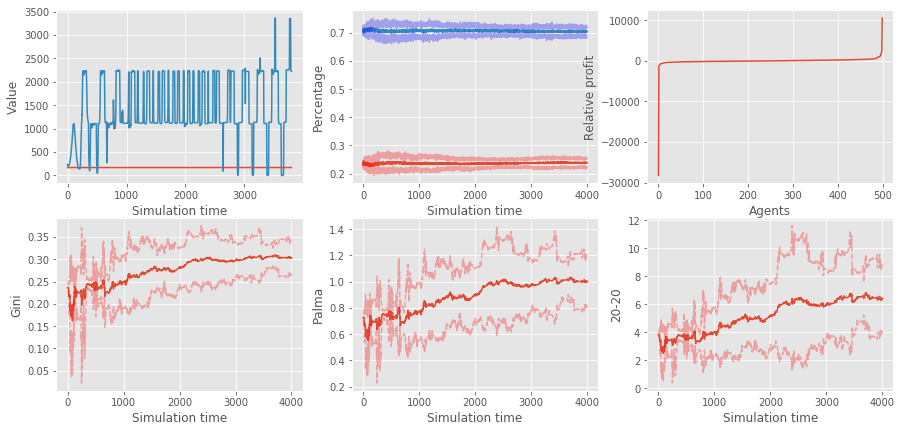

In [70]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), label='Market')
#ax1.plot(mc_prices.index, lower_c_price, 'b--', alpha=0.3)
#ax1.plot(mc_prices.index, upper_c_price, 'b--', alpha=0.3)

ax1.set_ylabel('Value', fontsize='12')
#ax1.legend(loc='best', fontsize='14')

ax2.plot(range(len(av_fundamentalist_sentiment[burn_in_period:])), av_fundamentalist_sentiment[burn_in_period:], label='fundamentalist ')
ax2.plot(range(len(lo_fundamentalist_sentiment[burn_in_period:])), lo_fundamentalist_sentiment[burn_in_period:], 'r--', alpha=0.3)
ax2.plot(range(len(up_fundamentalist_sentiment[burn_in_period:])), up_fundamentalist_sentiment[burn_in_period:], 'r--', alpha=0.3)
ax2.set_ylabel('Percentage', fontsize='12')

ax2.plot(range(len(av_trend_sentiment[burn_in_period:])), av_trend_sentiment[burn_in_period:], label='chartist ')
ax2.plot(range(len(lo_trend_sentiment[burn_in_period:])), lo_trend_sentiment[burn_in_period:], 'b--', alpha=0.3)
ax2.plot(range(len(up_trend_sentiment[burn_in_period:])), up_trend_sentiment[burn_in_period:], 'b--', alpha=0.3)

# ax2.plot(range(len(av_random_sentiment[burn_in_period:])), av_random_sentiment[burn_in_period:], 'k', label='random ')
# ax2.plot(range(len(lo_random_sentiment[burn_in_period:])), lo_random_sentiment[burn_in_period:], 'k--', alpha=0.3)
# ax2.plot(range(len(up_random_sentiment[burn_in_period:])), up_random_sentiment[burn_in_period:], 'k--', alpha=0.3)

ax3.plot(range(len(av_ordered_profits)), av_ordered_profits)
#ax3.hist(av_ordered_profits, bins=100)
#ax3.plot(range(len(av_ordered_profits)), ucf_ordered_profits, 'r--', alpha=0.3)
#ax3.plot(range(len(av_ordered_profits)), lcf_ordered_profits, 'r--', alpha=0.3)
ax3.set_ylabel('Relative profit', fontsize='12')
#ax3.set_ylim(-1.1, 3)

ax4.plot(range(len(av_gini_ot[burn_in_period:])), av_gini_ot[burn_in_period:])
ax4.plot(range(len(low_gini_ot[burn_in_period:])), low_gini_ot[burn_in_period:], 'r--', alpha=0.3)
ax4.plot(range(len(up_gini_ot[burn_in_period:])), up_gini_ot[burn_in_period:], 'r--', alpha=0.3)
ax4.set_ylabel('Gini', fontsize='12')

ax5.plot(range(len(av_gini_ot[burn_in_period:])), av_palma_ot[burn_in_period:])
ax5.plot(range(len(low_gini_ot[burn_in_period:])), low_palma_ot[burn_in_period:], 'r--', alpha=0.3)
ax5.plot(range(len(up_gini_ot[burn_in_period:])), up_palma_ot[burn_in_period:], 'r--', alpha=0.3)
ax5.set_ylabel('Palma', fontsize='12')

ax6.plot(range(len(av_gini_ot[burn_in_period:])), av_twtw_ot[burn_in_period:])
ax6.plot(range(len(low_gini_ot[burn_in_period:])), low_twtw_ot[burn_in_period:], 'r--', alpha=0.3)
ax6.plot(range(len(up_gini_ot[burn_in_period:])), up_twtw_ot[burn_in_period:], 'r--', alpha=0.3)
ax6.set_ylabel('20-20', fontsize='12')

for ax in (ax1, ax2, ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='12')
    
ax3.set_xlabel('Agents', fontsize='12')

fig.savefig('experiment2_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)